In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [2]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(30), transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.Resize(30), transforms.ToTensor(),])
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

In [3]:
data_dir = os.path.abspath(os.getcwd()) + '/mydata/'

In [4]:
trainloader, testloader = load_split_train_test(data_dir, .2)

In [5]:
classes = trainloader.dataset.classes
classes

['paper', 'rock', 'scissors']

In [6]:
len(trainloader.dataset), len(testloader.dataset)

(2188, 2188)

In [7]:
batch_size = 4

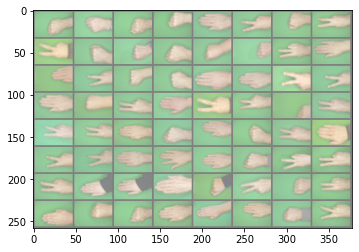

rock  rock  rock  rock 


In [8]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Net(nn.Module):
    def __init__(self, activate_dropout = True, dropout_probability = 0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        self.activate_dropout = activate_dropout
        self.dropout = nn.Dropout(p=dropout_probability)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        if self.activate_dropout:
            x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = torch.sigmoid (self.fc3(x))
        return x

In [11]:
net0 = Net(False, 0.2)

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net0.parameters(), lr=0.001, momentum=0.9)

In [13]:
class Classifier():
    def __init__(self):
        """
        constructs the Classifier
        """
        self.net = None
        
    def create_model(self, activate_dropout, dropout_probability):
        self.net = Net(activate_dropout, dropout_probability)
        
    def train(self, trainloader, criterion, optimizer):
        for epoch in range(5):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
                # print statistics
                running_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                    running_loss = 0.0

        print('Finished Training')
        
    def evaluate(self, testloader):
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = self.net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the {len(testloader.dataset)} test images: {100 * correct // total} %')

In [14]:
classifier = Classifier()
classifier.create_model(False, 0.2)
classifier.train(trainloader, criterion, optimizer)

Finished Training


In [15]:
classifier.evaluate(testloader)

Accuracy of the network on the 2188 test images: 35 %


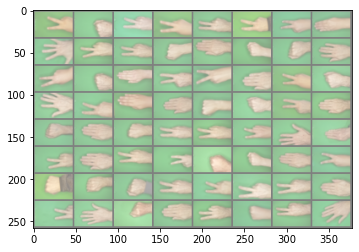

GroundTruth:  scissors rock  scissors scissors


In [16]:
#dataiter = iter(testloader)
dataiter = iter(trainloader)

images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [17]:
len(images)

64

In [18]:
outputs = classifier.net(images)

In [19]:
outputs = classifier.net(images)

In [20]:
len(outputs)

64

In [21]:
outputs

tensor([[0.5095, 0.5219, 0.4797],
        [0.5094, 0.5218, 0.4795],
        [0.5095, 0.5221, 0.4798],
        [0.5094, 0.5227, 0.4800],
        [0.5087, 0.5221, 0.4800],
        [0.5093, 0.5222, 0.4799],
        [0.5095, 0.5219, 0.4795],
        [0.5096, 0.5221, 0.4799],
        [0.5093, 0.5224, 0.4803],
        [0.5090, 0.5225, 0.4802],
        [0.5092, 0.5220, 0.4799],
        [0.5096, 0.5216, 0.4795],
        [0.5093, 0.5221, 0.4798],
        [0.5089, 0.5222, 0.4800],
        [0.5093, 0.5216, 0.4798],
        [0.5091, 0.5221, 0.4800],
        [0.5088, 0.5220, 0.4801],
        [0.5094, 0.5217, 0.4794],
        [0.5095, 0.5222, 0.4800],
        [0.5090, 0.5220, 0.4797],
        [0.5090, 0.5218, 0.4800],
        [0.5096, 0.5220, 0.4794],
        [0.5093, 0.5221, 0.4797],
        [0.5094, 0.5221, 0.4798],
        [0.5085, 0.5223, 0.4802],
        [0.5094, 0.5226, 0.4799],
        [0.5093, 0.5222, 0.4799],
        [0.5096, 0.5219, 0.4798],
        [0.5102, 0.5221, 0.4800],
        [0.509

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(10)))

Predicted:  rock  rock  rock  rock  rock  rock  rock  rock  rock  rock 


In [23]:
predicted

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])